In [4]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
# import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [5]:
import gc
gc.collect()

0

In [6]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device







Fri Jul 12 22:50:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 44%   66C    P2             218W / 250W |   5844MiB / 11264MiB |     86%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)
        # torch.nn.init.kaiming_normal_(self.fc1.weight)
        # torch.nn.init.kaiming_normal_(self.fc2.weight)
        # torch.nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [8]:
from imitation.util.util import make_vec_env

observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)

observations=observations.squeeze()
actions=actions.squeeze()

print(observations.shape, actions.shape)

# env=gym.make("HalfCheetah-v3",render_mode="rgb_array")
# env=make_vec_env("", n_envs=1, seed=0, render_mode="rgb_array")
env = make_vec_env(
    "seals:seals/HalfCheetah-v1",
    rng=np.random.default_rng(42),
    n_envs=1,
)




(50000, 18) (50000, 6)


In [9]:

class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [10]:
policy_network = PolicyNetwork(18,6).to(device)
prev = PolicyNetwork(18,6).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)

# Training loop
num_epochs = 40
batch_size = 32

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
score_graph=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//1
num_test = 10
now_log=0
now_pos=0
score=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    # now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        # now_log+=obs_batch.shape[0]
        # now_pos+=obs_batch.shape[0]
        model_act= torch.tanh( policy_network(obs_batch))
        loss= F.mse_loss(model_act,act_batch)

        optimizer.zero_grad()



        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        loss_graph.append(loss.detach().item())
        pbar.set_postfix({"loss":loss.detach().item(), "score":score})



        
        
    policy_network.eval()  # 切换到评估模式

    

    total_reward=0
    save_gif=True
    # test the policy and save as the first test as gif
    frames=[]
    for _ in range(num_test):
        state = env.reset()
        done = False
        while not done:
            state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
            with torch.no_grad():
                action= torch.tanh(policy_network(state_tensor))
                action.squeeze_()
            state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
            total_reward += reward
            # if save_gif:
            #     frames.append(env.render())
        save_gif=False
    image_path=f"{epoch}.gif"
    # imageio.mimsave("./gif/"+image_path, frames)


    score=total_reward/num_test
    score_graph.append(score)
    policy_network.train()  # 切换回训练模式
    


         

env.close()

Epoch [1/40]: 100%|██████████| 1563/1563 [00:06<00:00, 245.49it/s, loss=0.0275, score=0]
/tmp/ipykernel_330/2676155500.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
Epoch [40/40]: 100%|██████████| 1563/1563 [00:06<00:00, 231.98it/s, loss=0.034, score=[1653.8832]] 


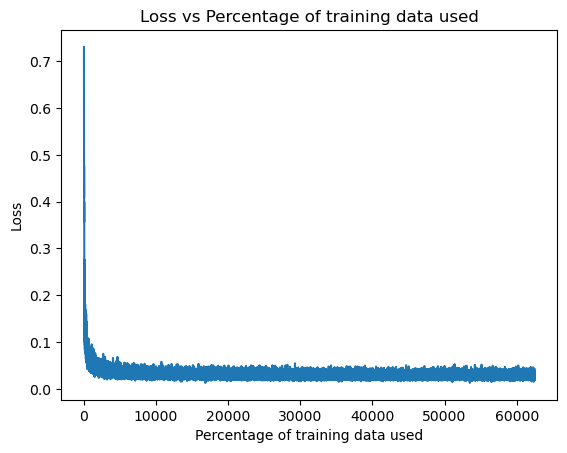

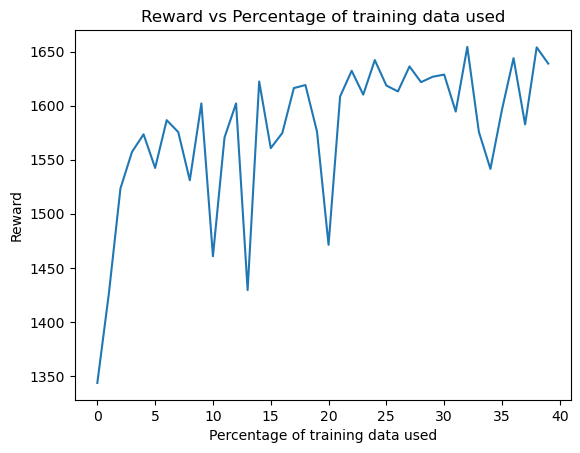

In [11]:
# draw the loss graph 
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Loss")
plt.title("Loss vs Percentage of training data used")

plt.savefig("./loss.png")
plt.show()
# draw the reward graph
plt.plot(score_graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Reward")
plt.title("Reward vs Percentage of training data used")
plt.savefig("./reward.png")
plt.show()
# save reward per epoc to csv
df = pd.DataFrame(score_graph, columns=["reward"])
df.to_csv("./reward.csv",index=False)
# save loss per epoc to csv
df = pd.DataFrame(loss_graph, columns=["loss"])
df.to_csv("./loss.csv",index=False)

